# **EE214 Project 2: CNN (ResNet)**

This is the second project for EE214 Machine Learning Basics and Practices.

&nbsp;

In this project, we will **implement ResNet18 and ResNet50** and perform **a classification task on the Fashion-MNIST dataset** using these models. Additionally, we will **achieve the highest possible accuracy score using any model and by only utilizing the resources available in Colab**. This project consists of the following components:

* **Part 1 (10 pts). Dataset visualization**
* **Part 2 (30 pts). Implement Building Blocks for ResNet**
* **Part 3 (30 pts). Implement ResNet18 and ResNet50**
* **Part 4 (10 pts). Train and visualize the results**
* **Part 5 (20 pts). Achieve the highest possible accuracy score.**


&nbsp;


## **Important**

* You have to write some description about your code and results for points in each part. For required sections, we will make the **markdown** box to write in and inform you what to write. Check **ALL** steps which have points.
* Your **submission** must be on the KLMS and includes two formats:
    * **[STUDENT_ID]_project2.ipynb**, e.g., 20XXXXX1.ipynb
    * **[STUDENT_ID]_project2.pdf**

In [1]:
# Importing the Required Library
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torchsummary import summary

import time

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

To train a model much faster, we'll use GPU source. Therefore, the runtime type must be changed to T4 GPU (Colab), and the below code should be compiled for using cuda. <br>
Furthermore, in Part 4, train() function is modified due to the change of PyTorch device. Modifications are specified inside the code.

In [2]:
# Set PyTorch device (use GPU or CPU)
# For faster training, we'll use GPU(cuda). Change runtime type as T4 GPU in Colab.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# If GPU is available, check CUDA version
if torch.cuda.is_available():
    !nvcc --version

cuda
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


# **Part 1 (Total 10 pts)**. Download and examine the Fashion-MNIST dataset
- In this project, we'll use the Fashion-MNIST dataset, which consists of 28x28 grayscale images of clothing.
- As you progress through **Part 1**, you'll download the dataset and examine its structure.

In [3]:
# Define the transformation to be applied to the data
transformations = transforms.Compose([transforms.ToTensor(),])

# Download the FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transformations)
test_dataset = datasets.FashionMNIST('./data', download=True, train=False, transform=transformations)

# Create DataLoader with subset of the dataset
def get_train_loader():
  indices = list(range(len(train_dataset)))
  sub_dataset_size = len(train_dataset) // 3
  random_indices = torch.randperm(len(indices)).tolist()
  subset_indices = random_indices[:sub_dataset_size]

  train_subset = Subset(train_dataset, subset_indices)
  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

  return train_loader

train_loader = get_train_loader()
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

print("Number of training data: %d" % len(train_dataset))
print("Number of test data: %d" % len(test_dataset))

100%|██████████| 26421880/26421880 [00:02<00:00, 10727028.91it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 173297.24it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3258683.89it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6714016.48it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Number of training data: 60000
Number of test data: 10000


### **$\color{red}{\text{ToDo}}$**: Visualize the dataset as shown in the illustration below. You don't need to replicate the exact results, but make sure to satisfy the following three conditions:

1. Ensure that at least one image for each label is included.
2. Plot a total of 30 or more samples.
3. Provide information about which label each sample belongs to alongside the plot.

![](https://drive.google.com/uc?export=view&id=1cotGY0lWW78uaObXs1xtIKMK58OuYhAd)

images.shape = torch.Size([64, 1, 28, 28]), labels.shape=torch.Size([64])


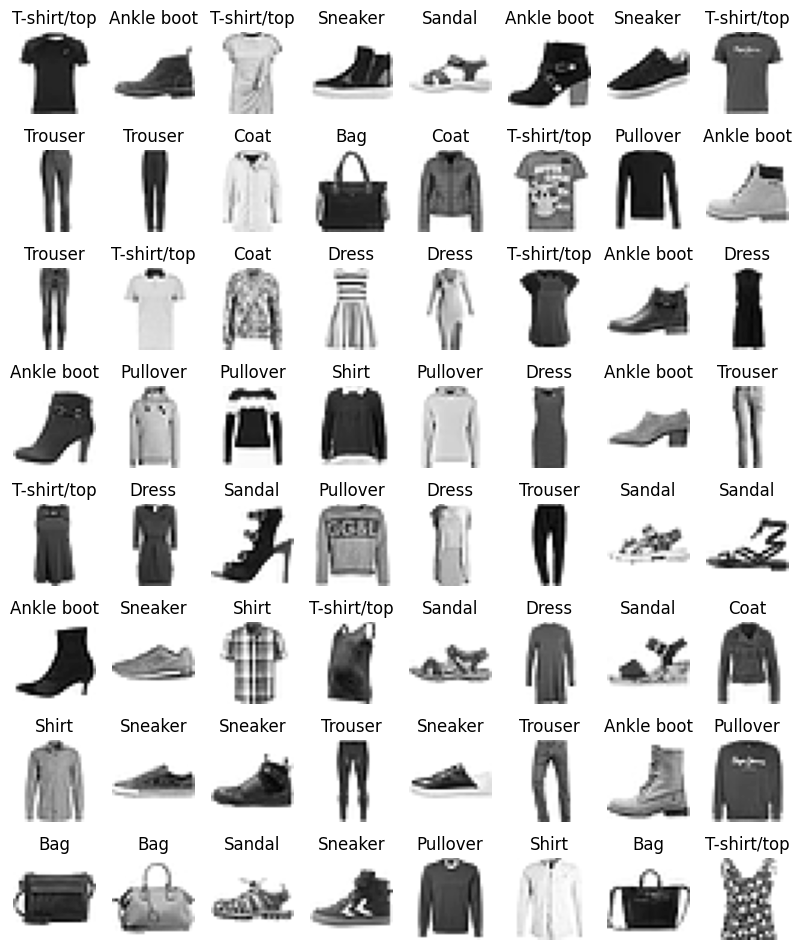

In [4]:
FASHION_LABELS = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

def display_sample(sample_images, sample_labels):

    ########## implement here ##########
    # Plot 8 x 8 = 64 images
    num_rows = 8
    num_cols = 8
    num_samples = num_rows * num_cols

    plt.figure(figsize=(10, 12))
    for i in range(num_samples):
        # 8 x 8 display (show all images in mini-batch)
        plt.subplot(num_rows, num_cols, i + 1)
        # show 28 x 28 2D image (not 3D like 1 x 28 x 28 )
        plt.imshow(sample_images[i,0,:,:], cmap = 'binary')
        ## Label visualization as title
        plt.title(FASHION_LABELS[sample_labels[i]])
        plt.axis('off')
        # Note that the current output shows all 10 labels at least once
        # However, re-compiling this code can omit some labels unfortunately.
    ####################################

    plt.show()
    plt.close()

# display a sample
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f'images.shape = {images.shape}, labels.shape={labels.shape}')
display_sample(images.cpu().numpy(), labels.cpu().numpy())

# **Part 2 (Total 30 pts)**. Implement Building Blocks for ResNet


- In ResNet, residual networks are implemented using the following two methods. The first is the Identity method, which uses a simple structure, as shown in the figure below. The second is the Projection method, which scales the dimensions through 1x1 convolution operations to reduce the number of parameters.

  <img src="https://drive.google.com/uc?export=view&id=16QzhXGKVS2XVxDf-5Nz-PZjQRL0dyntO" width="600" height="300" />

- In **Part 2**, we will implement the two types of blocks used in ResNet, the basic block and the bottleneck block.

## **Step 1 (Total 15 pts)**. Implement BasicBlock class

This class implements a basic building block for the Residual Network (ResNet) architecture. ResNet's design incorporates "shortcut" or "skip connections" to allow the gradient to be directly backpropagated through the network, addressing the vanishing/exploding gradient problem found in deeper networks. Each `BasicBlock` represents a residual block with two convolutional layers and a skip connection.

&nbsp;

### **$\color{red}{\text{ToDo}}$**: Fill in the blanks in the skeleton code below to complete the BasicBlock class. As can be seen in the following diagram, the BasicBlock consists of following elements:

```
(A 3x3 convolution that returns a vector of dimensions out_channels)
 ➡ (batch normalization)
 ➡ (relu)
 ➡ (A 3x3 convolution that returns a vector of dimensions out_channels)
 ➡ (batch normalization)
 ➡ residual with input vector
 ➡ relu
```

&nbsp;

The detailed guide for each element is as follows:


**1. First Convolution:**
   - When input data is given, this data first passes through a 3x3 convolutional layer.
   - During this process, depending on the 'stride' value, the size of the feature map may reduce.
   - After this operation, the number of channels changes to the value defined by the 'out_channels' parameter.

**2. Batch Normalization:**
   - The result after the convolution operation undergoes batch normalization.
   - This step normalizes each channel so that the mean is 0 and the variance is 1, increasing the stability of the network.

**3. Application of ReLU Activation Function:**
   - The result of batch normalization passes through the ReLU activation function, introducing non-linearity.
   - This aids the model in learning more complex patterns and features.

**4. Second Convolution:**
   - Next, the activated feature map passes through a second 3x3 convolutional layer.
   - The number of channels remains 'out_channels' here as well, and 'stride' is set to 1, meaning the size of the feature map remains unchanged.

**5. Second Batch Normalization:**
   - The result after the second convolution operation also undergoes batch normalization.

**6. Addition of the Shortcut:**
   - The original input (also known as the Residual or Shortcut) is added to the transformed feature map at this point.
   - If the dimensions of the input and output differ, the input is adjusted through a 1x1 convolution + batch normalization for dimension matching.
   - If the dimensions are the same, the original input is added directly without any alteration.
   - This step is crucial as it allows the network to retain fundamental information from the input data while still detecting changes.

**7. Application of the Final ReLU Activation Function:**
   - The result, combined from the shortcut and the convolution path, passes through the ReLU activation function once more.
   - This output is either passed on to the next layer or used as the final output, depending on the network's structure.



In [5]:
########## implement this class ##########

class BasicBlock(nn.Module):
    """
    Implements a BasicBlock architecture.

    Attributes:
    -----------
    expansion : int
        Class attribute representing the expansion factor for the block's output channels. For
        `BasicBlock`, this is always 1 as there is no expansion within the block itself.

    conv1 : nn.Conv2d
        The first convolutional layer in the block, applying filters to the input data with a
        kernel size of 3x3. The stride can be adjusted, affecting the output's height and width
        and serving as a mechanism for spatial down-sampling. This layer does not use bias.

    bn1 : nn.BatchNorm2d
        Batch Normalization for stabilizing the inputs to the second layer by adjusting and
        scaling the activations. Applied to the outputs of `conv1`.

    relu1 : nn.ReLU
        ReLU activation function applied after first batch normalization, introducing
        non-linearity and enhancing the network's learning capabilities.

    conv2 : nn.Conv2d
        The second convolutional layer with the same kernel size as `conv1` but with a fixed
        stride of 1, preserving the spatial dimensions of the data. This layer also does not use bias.

    bn2 : nn.BatchNorm2d
        Similar to `bn1`, this Batch Normalization layer normalizes the output from `conv2`,
        ensuring that the network remains stable during training.

    shortcut : nn.Sequential
        The skip connection providing a pathway for the original input to bypass the convolutional
        layers, facilitating the gradient flow during backpropagation. If the input and output dimensions
        are consistent, this remains an empty sequential block. If they differ (often due to a change
        in stride), this pathway adjusts the input's dimensions to match the output using a 1x1 convolution.

    relu2 : nn.ReLU
        The result, combined from the shortcut and the convolution path, passes through the ReLU activation function once more.
        This output is either passed on to the next layer or used as the final output, depending on the network's structure.

    Methods:
    --------
    __init__(self, input_channels: int, output_channels: int, stride: int = 1) -> None:
        Constructs all the necessary attributes for the BasicBlock object, including the convolutional
        layers, batch normalization, and the shortcut connection.

    forward(self, x: Tensor) -> Tensor:
        Defines the computation performed at every call, applying both convolutional layers to the input,
        then combining the output with the original input (the "shortcut") before returning the
        final activated result. This method is crucial for the 'torch.nn.Module' interface, as it handles
        the block's operations on input data.
    """

    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        # TODO: Define the first convolutional layer and batch normalization.
        # Remember to consider the number of input and output channels and the stride.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # TODO: Define a 1st activation function ReLU.
        self.relu1 = nn.ReLU()

        # TODO: Define the second convolutional layer and batch normalization.
        # The number of output channels remains the same as the first layer.
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # TODO: Define a shortcut layer that appropriately transforms the input to be added to the transformed feature map up to this point.
        # If input and output are the same dimensions, use an empty sequential model.
        # If the dimensions are different, adjust the layers accordingly using 1x1 convolution + batch normalization.
        if stride == 1 and in_channels == out_channels * self.expansion:  # Default is identity (no-operation)
          self.shortcut = nn.Sequential()

        else: # TODO: Add a layer to adjust dimensions in the shortcut path, if necessary, using 1x1 convolution + batch normalization.
          self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride),
                                        nn.BatchNorm2d(out_channels * self.expansion))

        # TODO: Define a 2nd activation function ReLU.
        self.relu2 = nn.ReLU()

    def forward(self, x):
        # TODO: Implement the forward function that applies the layers you have defined in the __init__.
        # Don't forget to add the input x to the output of the convolutional layers (skip connection).
        # conv1 : A 3x3 convolution that returns a vector of dimensions out_channels
        # ➡ bn1 : batch normalization
        # ➡ relu1 : relu
        # ➡ conv2 : A 3x3 convolution that returns a vector of dimensions out_channels
        # ➡ bn2 : batch normalization
        # ➡ shortcut : residual with input vector
        # ➡ relu1 : relu

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        shortcut = self.shortcut(x)
        out += shortcut

        out = self.relu2(out)

        return out

## **Step 2 (Total 15 pts)**. Implement Bottleneck block

This class implements the "Bottleneck" building block used in deeper Residual Network (ResNet) architectures. These blocks are designed with efficiency in mind, providing a more efficient way of increasing the depth of the network without a significant increase in computational complexity. The main feature of a Bottleneck block is the use of 1x1 convolutions to reduce and subsequently restore dimensions, ensuring that the 3x3 convolution has a minimal computational load.

&nbsp;

### **$\color{red}{\text{ToDo}}$**: Fill in the blanks in the skeleton code below to complete the Bottleneck class. As can be seen in the following diagram, the Bottleneck class consists of following elements:

```
(A 1x1 convolution that returns a vector of dimensions out_channels)
 ➡ (batch normalization)
 ➡ (relu)
 ➡ (A 3x3 convolution that returns a vector of dimensions out_channels)
 ➡ (batch normalization)
 ➡ (relu)
 ➡ (A 1x1 convolution that returns a vector of dimensions out_channels*4)
 ➡ (batch normalization)
 ➡ residual with input vector
 ➡ relu
```

**1. First Convolution (1x1 kernels):**
   - The data first passes through a 1x1 convolutional layer. Despite its simplicity, this layer is instrumental in reducing the dimensionality, as it affects the depth of the feature maps (i.e., the number of channels).
   - This layer performs initial feature transformation, preparing the data for the next step of processing.

**2. First Batch Normalization and ReLU Activation:**
   - Subsequent to convolution, the model normalizes the batch using Batch Normalization. This step is crucial for maintaining consistent mean and variance, improving the stability and speed of the training process.
   - After normalization, the feature map goes through a ReLU activation function, providing the non-linearity necessary for the model to learn complex patterns.

**3. Second Convolution (3x3 kernels):**
   - The second layer is a 3x3 convolution, the central part of the bottleneck. It's where the spatial features are primarily learned, without any change in the depth of the feature maps.
   - This convolution is more computational efficient due to the reduced dimensionality from the previous 1x1 convolution.

**4. Second Batch Normalization and ReLU Activation:**
   - The model normalizes the results of the second convolution before applying another ReLU activation.
   - This step is necessary for ensuring the model does not produce outputs with high variance or learn inefficient representations.

**5. Third Convolution (1x1 kernels):**
   - The third layer involves another 1x1 convolution. This stage is crucial as it restores the depth of the feature maps, often expanding it to be ready for addition with the shortcut.
   - It allows the network to learn more abstract features by reintroducing depth to the feature maps.

**6. Third Batch Normalization:**
   - Similar to previous layers, batch normalization is applied to standardize the feature maps, preparing them for the shortcut connection.

**7. Shortcut Connection and Final ReLU Activation:**
   - The shortcut (or residual connection) is then added back to the main pathway. If the input needs to be resized to match the output dimensions, a 1x1 convolution is applied to the shortcut connection.
   - After adding the shortcut, the block applies a ReLU activation function to introduce non-linearity, making the output the final result of this block.

In [6]:
########## implement this class ##########

class Bottleneck(nn.Module):

    """
    Implements a Bottleneck architecture.

    Attributes:
    -----------
    expansion : int
        Class attribute representing the expansion factor for the output channels at the end of
        the block. This attribute multiplies the number of channels in the block, typically
        increasing the depth by 4 times in a standard Bottleneck block.

    conv1 : nn.Conv2d
        The first layer in the bottleneck, a 1x1 convolution. This layer reduces the number of
        channels, preparing the input for the next 3x3 convolution. It is designed without a bias term.

    bn1 : nn.BatchNorm2d
        Batch Normalization for the first convolution, stabilizing the activations and improving
        the training process.

    relu1 : nn.ReLU
        ReLU activation function applied after first batch normalization, introducing
        non-linearity and enhancing the network's learning capabilities.

    conv2 : nn.Conv2d
        The central layer of the bottleneck, a 3x3 convolution. This layer maintains the number
        of channels but can alter the spatial dimensions based on the stride. It is also designed
        without a bias term.

    bn2 : nn.BatchNorm2d
        Batch Normalization for the central convolutional layer, providing the same benefits as `bn1`.

    relu2 : nn.ReLU
        ReLU activation function applied after central batch normalization.

    conv3 : nn.Conv2d
        The final layer in the bottleneck, a 1x1 convolution. This layer expands the number of
        channels by the factor defined in `expansion`, increasing the depth of the feature map.
        This convolution is also without a bias term.

    bn3 : nn.BatchNorm2d
        Batch Normalization for the final convolution, ensuring the network's stability as the depth increases.

    shortcut : nn.Sequential
        A sequential container for the 'shortcut' or 'skip connection'. When the input and output
        dimensions differ, due to either a stride not equal to 1 or a difference in the number of channels,
        this pathway contains a 1x1 convolution that adjusts the input's dimensions to match the output.

    relu3 : nn.ReLU
        After adding the shortcut, the block applies a ReLU activation function to introduce non-linearity,
        making the output the final result of this block.

    Methods:
    --------
    __init__(self, in_channels: int, out_channels: int, stride: int = 1) -> None:
        Initializes the Bottleneck block with its convolutional layers, batch normalization,
        and prepares the shortcut connection.

    forward(self, x: Tensor) -> Tensor:
        Defines the computation performed at every call. The input passes through each layer of the
        bottleneck, with a skip connection adding the input of the block to its output. This method
        applies the ReLU activation function after each addition and finally returns the resulting tensor.
    """

    # This value is used to adjust the number of output channels in the layer, e.g., out_channels * expansion.
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()

        # TODO: Define the first 1x1 convolution layer.
        # It should take in_channels and return out_channels.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()

        # TODO: Define the second 3x3 convolution layer.
        # It should take out_channels and return out_channels, possibly performing downsampling using stride and padding.
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()

        # TODO: Define the third 1x1 convolution layer.
        # It should take out_channels and return out_channels * expansion.
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        # TODO: Shortcut definition for skip connection & Final ReLU
        self.shortcut = nn.Sequential()  # Default is identity (no-operation)
        if stride != 1 or in_channels != out_channels * self.expansion:
            # TODO: Add a layer to adjust dimensions in the shortcut path, if necessary, using 1x1 convolution + batch normalization.
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * self.expansion))

        self.relu3 = nn.ReLU()

    def forward(self, x):
        # TODO: Implement the forward function that applies the layers you have defined in the __init__.
        # Don't forget to add the input x to the output of the convolutional layers (skip connection).

        # Step 1. 1x1 convolution layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        # Step 2. 3x3 convolution layer
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)

        # Step 3. 1x1 convolution layer
        out = self.conv3(out)
        out = self.bn3(out)

        # Step 4. Shortcut layer connection and final ReLU
        shortcut = self.shortcut(x)
        out += shortcut
        out = self.relu3(out)

        return out  # Return the final output

# **Part 3 (Total 30 pts)**. Implement ResNet18 and ResNet50
- In **Part 3**, we will implement ResNet18 and ResNet50 using the Basic block and Bottleneck block that we implemented in Part 2.
- The architectural configuration of ResNet18 and ResNet50 is as shown in the figure below, and one [*] represents a basic/bottleneck block.

  <img src="https://drive.google.com/uc?export=view&id=1lY6jHixjUNKYpiw0Nho0XyLzlHuvhmGh" width="700" height="330" />
- First, we will implement a common ResNet class that can be used to build both ResNet18 and ResNet50, and through this, we will create each model.

## **Step 1 (Total 25 pts)**. Implement ResNet Class

### **$\color{red}{\text{ToDo}}$**: Using the detailed description provided, complete the ResNet class by filling in the blanks in the following skeleton code.

**1. Initial Setup:**
   - ResNet class initializes with parameters specifying the type of block to use, the number of blocks, and the number of classes for classification.
   - The initial number of channels, specifically, `in_channels`, is set to 64.

**2. Initial Convolutional Layer and Max Pooling:**

   - Initial Convolutional Layer: This layer (`self.conv1`) employs 64 filters of size 7x7 with a stride of 2 and padding of 3.

   - Batch Normalization: Following the convolution, the model applies batch normalization via `self.bn1` to standardize the activations of the previous layer. This process helps stabilize and accelerate the learning process.

   - ReLU Activation: After the convolution, the model applies a ReLU activation function (`self.relu`).

   - Max Pooling: Subsequent to the initial convolutional layers, the ResNet model incorporates a max-pooling layer (`self.maxpool`). This layer, with a kernel size of 3x3, stride of 2, and padding of 1, reduces the spatial dimensions by taking the maximum value of features, helping the model eliminate redundant information and retain only crucial features.

**3. Constructing Residual Layers:**
   - Four main layers (each a sequence of blocks) follow the initial convolution. Each layer uses the `_make_layer` function to create a series of residual blocks.
   - `self.layer1` is composed of `num_blocks[0]` blocks, each outputting 64 channels and using a stride of 1 for maintaining the spatial dimensions of the feature maps.
   - `self.layer2` consists of `num_blocks[1]` blocks, increasing the number of channels to 128. With the appropriate stride, it effectively halves the dimensions of the feature maps while increasing their depth for a more complex feature representation.
   - `self.layer3` is structured with `num_blocks[2]` blocks, further enhancing the capacity by increasing the channels to 256. It continues the trend of reducing spatial dimensions by half and doubling the depth, allowing the network to learn even more complex patterns in the input data.
   - `self.layer4` forms the deepest segment of the architecture, comprising `num_blocks[3]` blocks, each contributing to a total of 512 channels. This layer continues to compact the spatial dimensions and enhance the representational depth, making the network capable of understanding highly abstract features present in the data.


**4. Residual Block Creation (`_make_layer` method):**
   - This method creates a sequence of residual blocks. The first block in each sequence might use a stride not equal to 1 for dimensionality reduction.
   - For each block, it adjusts the number of input channels (`self.in_channels`) and the number of output channels, ensuring that the subsequent block receives the correct number of input channels.
   - It stacks these blocks sequentially to form a complete layer.

**5. Forward Pass:**
   - The `forward` method defines the data flow through the network:
     - The input data `x` goes through the initial convolution, batch normalization, and ReLU activation.
     - It then sequentially passes through each of the four layers of residual blocks (`self.layer1`, `self.layer2`, `self.layer3`, `self.layer4`).
     - Following the residual layers, a global average pooling is performed reducing the spatial dimensions to 1x1.
     - The pooled output is then flattened and finally, a linear layer (`self.linear`) classifies the features into `num_classes` categories.

In [7]:
########## implement this class ##########
"""
      Implements a Residual Network (ResNet) architecture.

      The ResNet architecture is designed with deep residual learning to ease the training of
      networks that are substantially deeper than those used previously. This class creates a
      customizable ResNet model by stacking layers of residual blocks, performing initial
      convolution, and final classification using a fully connected layer.

      Attributes:
      -----------
      in_channels : int
          The number of channels in the input data. Initialized to 64 for the first layer.
      conv1 : nn.Conv2d
          The first convolutional layer which applies 64 filters with a 7x7 kernel, stride of 2,
          and padding of 3.
      bn1 : nn.BatchNorm2d
          Batch Normalization for the first convolutional layer.
      relu : nn.ReLU
          ReLU activation function used after batch normalization.
      maxpool : nn.MaxPool2d
          Max pooling with a 3x3 kernel, stride of 2, and padding of 1.
      layer1-4 : nn.Sequential
          Layers of residual blocks, with the number of blocks and output channels varying
          per layer. Each individual layer is created by the _make_layer private method.
      linear : nn.Linear
          The final fully connected layer that outputs the classification results.

      Methods:
      --------
      __init__(self, block, num_blocks, num_classes=10):
          Initializes the ResNet with the given block type, list of integers representing the
          number of blocks in each layer, and the number of classification classes.

      _make_layer(self, block, output_channels, num_blocks, stride):
          Helper function to create a layer of residual blocks with the specified number of blocks,
          output channels, and the initial stride.

      forward(self, x):
          Defines the forward pass of the input through the ResNet architecture. The input data 'x'
          passes sequentially through the initial convolution (with batch normalization and ReLU),
          max pooling, four residual layers, and finally, the fully connected layer for classification.
          The output of this method is the classification result of the input.
          """
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64  # Starting number of channels

        # TODO: Define the initial convolutional layer and batch normalization.
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 7, stride = 2, padding = 3) # 64 filters of size 7x7 with a stride of 2 and padding of 3
        self.bn1 = nn.BatchNorm2d(64) # standardize the activations of the previous layer
        self.relu = nn.ReLU() # Add a non-linearity to model
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) #  reduces the spatial dimensions by taking the maximum value of features

        # Define layers consisting of BasicBlocks. Each layer may contain multiple blocks.
        # The number of blocks for each layer is specified in num_blocks.
        # TODO: Define the four layers of the ResNet (self.layer1 to self.layer4) using the '_make_layer' function.
        # Note that for self.layer2, 3, 4, halves the dimensions of the feature maps while increasing their depth for a more complex feature representation
        # while self.layer1 maintaining the spatial dimensions of the feature maps.

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride = 1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride = 2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride = 2)

        # Reducing dimension with selecting appropriate pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        # TODO: Define the final fully connected layer that maps the output of the convolutional layers to the classes.
        self.linear = nn.Linear(in_features = 512 * block.expansion, out_features = 10)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        # This function creates a sequential layer for each set of blocks.
        # TODO: Implement the function that creates each layer. You will need to consider the stride for the first block
        # and make sure subsequent blocks maintain the output dimension.
        # Update self.in_channels as needed.
        layers = []
        stride_list = [stride] + [1] * (num_blocks - 1)

        for s in stride_list:
          # Note that for each layer, only initial block has a stride that specified in parameter, for dimensionality reduction.
          # Other blocks have a stride with 1.
          layers.append(block(self.in_channels, out_channels, stride = s ))
          self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # TODO: Implement the forward function. Apply the layers defined in the __init__ to the input x.
        # The initial convolutional layer and batch normalization. Dimension reduction occurs by maxpool.
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        # Passing the data through four layers (each layers have multiple Basicblock or Bottleneck)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # Finally, apply average pooling and a fully connected layer for the classification.
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

## **Step 2 (Total 5 pts)**. Construct and check your ResNet18 and ResNet50

Note that when the model runs on GPU, then the device should be changes by implementation.

In [19]:
# To use GPU for training, attach to(device) method at the end of each model.
# Define the ResNet18 model using the previously defined BasicBlock and ResNet class.
resnet18_model = ResNet(block=BasicBlock,
                   num_blocks=[2, 2, 2, 2],
                   num_classes=10)
summary(resnet18_model.to(device), (1, 28, 28))

# Define the ResNet50 model using the previously defined Bottleneck block and ResNet class.
resnet50_model = model = ResNet(block=Bottleneck,
                   num_blocks=[3, 4, 6, 3],
                   num_classes=10)
summary(resnet50_model.to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,928
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,928
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

# **Part 4 (Total 10 pts)**. Train and visualize the results

In [20]:
# Hyperparameters
random_seed = 7
learning_rate = 0.001
batch_size = 128
num_epochs = 5

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_metric(metric_fn, true_y, pred_y):
    try:
      return metric_fn(true_y, pred_y, average="macro")
    except:
      return metric_fn(true_y, pred_y)

def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

To use GPU, features and targets data also should be sended to GPU as the model.<br>
Plot the training loss and validation loss for each epoch.

In [11]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def train(model, optimizer):
    # List that stacking the train loss / validation loss for each epoch
    train_losses = []
    validation_losses = []

    val_batches = len(test_loader)

    start_time = time.time()
    for epoch in range(num_epochs):
        total_loss = 0

        # ----------------- TRAINING  --------------------
        # set model to training

        train_loader = get_train_loader()
        batches = len(train_loader)

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):
            # To use GPU, sending a dataset to GPU.
            features, targets = features.to(device), targets.to(device)
            logits = model(features)
            loss = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

            current_loss = loss.item()
            total_loss += current_loss

            if not batch_idx % 10:
                print ('Epoch: %d/%d | Batch %d/%d | loss: %.4f' %(epoch+1, num_epochs, batch_idx, len(train_loader), current_loss))

        # ----------------- VALIDATION  -----------------
        val_losses = 0
        precision, recall, f1, accuracy = [], [], [], []

        # set model to evaluating (testing)

        model.eval()
        with torch.no_grad():
            for batch_idx, (features, targets) in enumerate(test_loader):
                # To use GPU, sending a dataset to GPU.
                features, targets = features.to(device), targets.to(device)
                logits = model(features) # this get's the prediction from the network

                # IMPORTANT! To avoid an error, Use item method for moving data to cpu
                val_losses += F.cross_entropy(logits, targets).item()

                predicted_classes = torch.max(logits, 1)[1] # get class from network's prediction

                # calculate P/R/F1/A metrics for batch
                for acc, metric in zip((precision, recall, f1, accuracy),
                                    (precision_score, recall_score, f1_score, accuracy_score)):
                    acc.append(
                        calculate_metric(metric, targets.cpu(), predicted_classes.cpu())
                    )

        print(f"Epoch {epoch+1}/{num_epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
        print_scores(precision, recall, f1, accuracy, val_batches)
        train_losses.append(total_loss/batches) # for plotting training loss curve
        validation_losses.append(val_losses/val_batches) # for plotting validation loss curve

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    # Plot training loss for each epoch
    epoch_list = [i+1 for i in range(num_epochs)]

    plt.plot(epoch_list, train_losses, label='Training loss')
    plt.plot(epoch_list, validation_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel("Average Loss")

    plt.xticks(epoch_list)
    plt.grid(visible=True)
    plt.legend()

    return train_losses

## **Step 1 (Total 5 pts)**. Train the ResNet18 and display the training and testing losses for ResNet18 as a graph.
### **$\color{red}{\text{ToDo}}$**: Train your ResNet18 using below code and plot the training loss and validation loss against the epochs. (You can modify the training code as needed.)

Epoch: 1/5 | Batch 0/938 | loss: 2.6291
Epoch: 1/5 | Batch 10/938 | loss: 1.1720
Epoch: 1/5 | Batch 20/938 | loss: 0.7852
Epoch: 1/5 | Batch 30/938 | loss: 0.9591
Epoch: 1/5 | Batch 40/938 | loss: 0.7013
Epoch: 1/5 | Batch 50/938 | loss: 0.6535
Epoch: 1/5 | Batch 60/938 | loss: 0.5958
Epoch: 1/5 | Batch 70/938 | loss: 0.6053
Epoch: 1/5 | Batch 80/938 | loss: 0.7855
Epoch: 1/5 | Batch 90/938 | loss: 0.6017
Epoch: 1/5 | Batch 100/938 | loss: 0.7556
Epoch: 1/5 | Batch 110/938 | loss: 0.8089
Epoch: 1/5 | Batch 120/938 | loss: 0.7158
Epoch: 1/5 | Batch 130/938 | loss: 0.7979
Epoch: 1/5 | Batch 140/938 | loss: 0.5972
Epoch: 1/5 | Batch 150/938 | loss: 0.4121
Epoch: 1/5 | Batch 160/938 | loss: 0.3905
Epoch: 1/5 | Batch 170/938 | loss: 0.5765
Epoch: 1/5 | Batch 180/938 | loss: 0.4911
Epoch: 1/5 | Batch 190/938 | loss: 0.6323
Epoch: 1/5 | Batch 200/938 | loss: 0.5085
Epoch: 1/5 | Batch 210/938 | loss: 0.5880
Epoch: 1/5 | Batch 220/938 | loss: 0.5585
Epoch: 1/5 | Batch 230/938 | loss: 0.4149
Epo

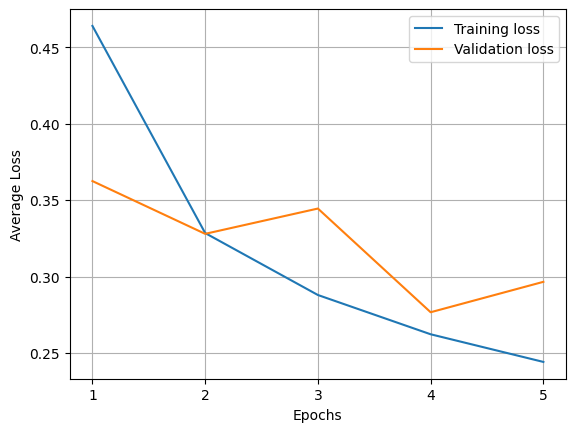

In [21]:
num_epochs = 5
optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=learning_rate)

losses = train(resnet18_model, optimizer)

## **Step 2 (Total 5 pts)**. Train the ResNet50 and display the training and testing losses for ResNet50 as a graph.
### **$\color{red}{\text{ToDo}}$**: Train your ResNet50 using below code and plot the training loss and validation loss against the epochs. (You can modify the training code as needed.)

Epoch: 1/5 | Batch 0/938 | loss: 2.8762
Epoch: 1/5 | Batch 10/938 | loss: 1.8106
Epoch: 1/5 | Batch 20/938 | loss: 1.2379
Epoch: 1/5 | Batch 30/938 | loss: 0.9419
Epoch: 1/5 | Batch 40/938 | loss: 0.9554
Epoch: 1/5 | Batch 50/938 | loss: 0.8376
Epoch: 1/5 | Batch 60/938 | loss: 1.0012
Epoch: 1/5 | Batch 70/938 | loss: 1.0465
Epoch: 1/5 | Batch 80/938 | loss: 1.7959
Epoch: 1/5 | Batch 90/938 | loss: 0.8518
Epoch: 1/5 | Batch 100/938 | loss: 0.5956
Epoch: 1/5 | Batch 110/938 | loss: 0.8406
Epoch: 1/5 | Batch 120/938 | loss: 0.6253
Epoch: 1/5 | Batch 130/938 | loss: 0.7042
Epoch: 1/5 | Batch 140/938 | loss: 0.6271
Epoch: 1/5 | Batch 150/938 | loss: 0.7240
Epoch: 1/5 | Batch 160/938 | loss: 0.9108
Epoch: 1/5 | Batch 170/938 | loss: 0.6423
Epoch: 1/5 | Batch 180/938 | loss: 0.7685
Epoch: 1/5 | Batch 190/938 | loss: 1.1372
Epoch: 1/5 | Batch 200/938 | loss: 0.6618
Epoch: 1/5 | Batch 210/938 | loss: 0.6494
Epoch: 1/5 | Batch 220/938 | loss: 0.3746
Epoch: 1/5 | Batch 230/938 | loss: 0.3858
Epo

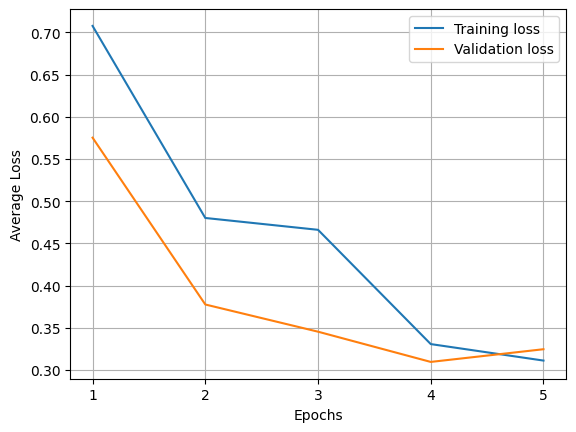

In [22]:
num_epochs = 5
optimizer = torch.optim.Adam(resnet50_model.parameters(), lr=learning_rate)

losses = train(resnet50_model, optimizer)

 # **Part 5 (Total 20 pts)**. Achieve the highest possible **accuracy score** on the test dataset for the Fashion-MNIST classification task using only the basic Colab resources.

* **You can use any model**, including the ResNet you implemented, as long as **it can be trained within the Colab resources**.
* To receive points for your score, **the model and the training process used to achieve that score must be accurately documented in your submitted file.**
* You may modify `train_loader`, `train()` as necessary, but `test_loader` should not be modified.

- Part5 score will be given based on the achieved accuracy score like the followings:
  - 0.93 ~ : 20 pts
  - 0.90 ~ 0.93 : 15 pts
  - 0.88 ~ 0.90 : 10 pts
  - 0.85 ~ 0.88 : 5 pts


To improve a model with higher accuracy (goal : 0.93), the model is modified with below specifications.
- Resnet18 with different initial convolutional layer: Using simple model (e.g. a few convolutional layers) shows a lack of capacity and cause underfitting, while complex model(e.g. Resnet with many layers) shows an overfitting problem easily and train longer. Therefore, we'll use a model based on a structure of Resnet18. <br>
For this model, **initial convolutional layer is modified by (kernel_size, stride, padding) = (3, 1, 1), instead of (7, 2, 3) combination.** This makes the kernel becomes small, but allows stronger locality. Also, it can be fit to the small data size, like 28 x 28 pixel image.
- Data Augmentation : Apply a data augmentation on **training data** to increase the size of the training set and to get more different images. We'll only transform the training set images by changing the brightness using **transforms.ColorJitter method**, because the image has a small size, so spatial transformation can make a huge different between the original data.

  **Important!!** Test dataset should not be modified, which means the data augmentation doesn't applied at the test dataset.
- Regularization with dropout : Placing a dropout layer inside the BasicBlock forward process and also the Resnet's fully connected layer. This regularization can prevent the overfitting.
- More training : increase the number of epochs from 5 to 30. This change will make model more accurate, but the model will fall into the overfitting and accuracy won't increase soon.

First, we'll consider the data augmentation.  


In [14]:
# Data Augmentation
# Define the transformation to be applied to the data
train_transformations = transforms.Compose([  transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0, hue=0), transforms.ToTensor()])

# Download the FashionMNIST dataset with Data Augmentation
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transformations)

train_loader = get_train_loader()

print("Number of training data: %d" % len(train_dataset))
print("Number of test data: %d" % len(test_dataset))

Number of training data: 60000
Number of test data: 10000


Then. we'll implement the modified BasicBlock and Resnet class, called **BasicBlock_rev** and **Resnet_rev**, respectively. <br>
In BasicBlock_rev, dropout layer with rate 0.2 applied before the second convolutional layer.

In [15]:
########## implement this class ##########

class BasicBlock_rev(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock_rev, self).__init__()

        # TODO: Define the first convolutional layer and batch normalization.
        # Remember to consider the number of input and output channels and the stride.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # TODO: Define a 1st activation function ReLU.
        self.relu1 = nn.ReLU()

        # TODO: Define the second convolutional layer and batch normalization.
        # The number of output channels remains the same as the first layer.
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # TODO: Define a shortcut layer that appropriately transforms the input to be added to the transformed feature map up to this point.
        # If input and output are the same dimensions, use an empty sequential model.
        # If the dimensions are different, adjust the layers accordingly using 1x1 convolution + batch normalization.
        if stride == 1 and in_channels == out_channels * self.expansion:  # Default is identity (no-operation)
          self.shortcut = nn.Sequential()

        else: # TODO: Add a layer to adjust dimensions in the shortcut path, if necessary, using 1x1 convolution + batch normalization.
          self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride),
                                        nn.BatchNorm2d(out_channels * self.expansion))

        # TODO: Define a 2nd activation function ReLU.
        self.relu2 = nn.ReLU()

        # Dropout Layer
        self.drop = nn.Dropout2d(0.2)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        # Apply dropout layer after the first activation function
        out = self.drop(out)

        out = self.conv2(out)
        out = self.bn2(out)

        shortcut = self.shortcut(x)
        out += shortcut

        out = self.relu2(out)

        return out

In Resnet_rev, dropout layer with rate 0.5 applied before the linear layer. Also, at the initial convolutional layer conv1, (kernel_size, stride, padding) change from (7,2,3) to (3,1,1).

In [16]:
class ResNet_rev(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_rev, self).__init__()
        self.in_channels = 64  # Starting number of channels

        # TODO: Define the initial convolutional layer and batch normalization.
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Define layers consisting of BasicBlocks. Each layer may contain multiple blocks.
        # The number of blocks for each layer is specified in num_blocks.
        # TODO: Define the four layers of the ResNet (self.layer1 to self.layer4) using the '_make_layer' function.
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride = 1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride = 2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        # TODO: Define the final fully connected layer that maps the output of the convolutional layers to the classes.
        self.linear = nn.Linear(in_features = 512 * block.expansion, out_features = 10)

        # Dropout Layer
        self.drop = nn.Dropout2d(0.5)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        # This function creates a sequential layer for each set of blocks.
        # TODO: Implement the function that creates each layer. You will need to consider the stride for the first block
        # and make sure subsequent blocks maintain the output dimension.
        # Update self.in_channels as needed.
        layers = []
        stride_list = [stride] + [1] * (num_blocks - 1)

        for s in stride_list:
          layers.append(block(self.in_channels, out_channels, stride = s ))
          self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # TODO: Implement the forward function. Apply the layers defined in the __init__ to the input x.
        # Finally, apply average pooling and a fully connected layer for the classification.
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)


        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        # Apply dropout layer(p=0.5) before the linear layer
        out = self.drop(out)
        out = self.linear(out)

        return out

Let's create a new Resnet18_rev model! <br>
Note that still, the model runs on GPU. <br>
If you see the summary below, dropout layers are successfully added between the layers.

In [17]:
Resnet18_rev_model = ResNet_rev(block=BasicBlock_rev,
                   num_blocks=[2, 2, 2, 2],
                   num_classes=10)
summary(Resnet18_rev_model.to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          36,928
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         Dropout2d-8           [-1, 64, 14, 14]               0
            Conv2d-9           [-1, 64, 14, 14]          36,928
      BatchNorm2d-10           [-1, 64, 14, 14]             128
             ReLU-11           [-1, 64, 14, 14]               0
   BasicBlock_rev-12           [-1, 64, 14, 14]               0
           Conv2d-13           [-1, 64, 14, 14]          36,928
      BatchNorm2d-14           [-1, 64,

Train the model with larger num_epochs.

Epoch: 1/30 | Batch 0/938 | loss: 2.5779
Epoch: 1/30 | Batch 10/938 | loss: 1.0650
Epoch: 1/30 | Batch 20/938 | loss: 1.0453
Epoch: 1/30 | Batch 30/938 | loss: 0.8953
Epoch: 1/30 | Batch 40/938 | loss: 1.0134
Epoch: 1/30 | Batch 50/938 | loss: 0.7812
Epoch: 1/30 | Batch 60/938 | loss: 0.7361
Epoch: 1/30 | Batch 70/938 | loss: 0.6460
Epoch: 1/30 | Batch 80/938 | loss: 0.5031
Epoch: 1/30 | Batch 90/938 | loss: 0.6433
Epoch: 1/30 | Batch 100/938 | loss: 0.4011
Epoch: 1/30 | Batch 110/938 | loss: 0.7789
Epoch: 1/30 | Batch 120/938 | loss: 0.3593
Epoch: 1/30 | Batch 130/938 | loss: 0.7009
Epoch: 1/30 | Batch 140/938 | loss: 0.6439
Epoch: 1/30 | Batch 150/938 | loss: 0.7226
Epoch: 1/30 | Batch 160/938 | loss: 0.4863
Epoch: 1/30 | Batch 170/938 | loss: 0.5210
Epoch: 1/30 | Batch 180/938 | loss: 0.3606
Epoch: 1/30 | Batch 190/938 | loss: 0.4517
Epoch: 1/30 | Batch 200/938 | loss: 0.4126
Epoch: 1/30 | Batch 210/938 | loss: 0.4265
Epoch: 1/30 | Batch 220/938 | loss: 0.4495
Epoch: 1/30 | Batch 23

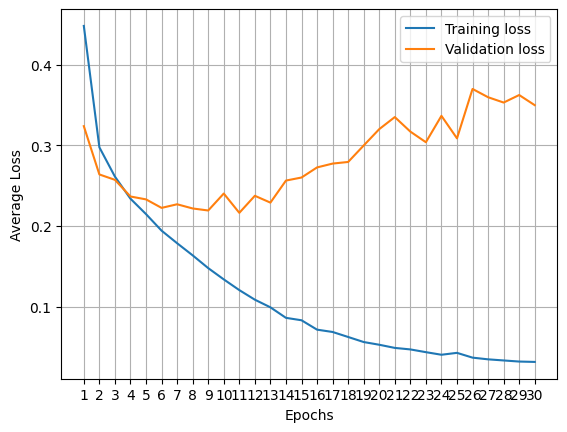

In [18]:
num_epochs = 30
optimizer = torch.optim.Adam(Resnet18_rev_model.parameters(), lr=learning_rate)

losses = train(Resnet18_rev_model.to(device), optimizer)

**At *epoch 13*, the model reaches the maximum accuracy 0.9335, which pass the goal accuracy 0.93!** <br>
Resnet18 without modifications shows a best accuracy around 0.91 in epoch 5.
After model changes, the model shows the accuracy with 0.9113 in epoch 5 and increase further. However, after few epochs, validation loss tends to increase by overfitting. It means that the model accuracy is highest at epoch 13, but there might be some critical large loss(error) on a few data.